<table width="100%">
    <td align="left">
        <a target="_blank", href="https://www.up.pt/fcup/en/">
            <img src="https://divulgacao.iastro.pt/wp-content/uploads/2023/03/FCUP_logo-print_blcktransp_600ppi.png" width="90px" height="90px" style="padding-bottom:5px;"/>
        </a>
    </td>
    <td>
        <a target="_blank", href="https://www.iastro.pt/">
            <img src="https://divulgacao.iastro.pt/wp-content/uploads/2018/03/IA_logo_bitmap-rgbblack-1200px-388x259.png" width="90px" height="90px" style="padding-bottom:5px;"/>
        </a>
    </td>
    <td align="center">
        <a target="_blank" href="https://colab.research.google.com/github/jbrinchmann/MLD2025/blob/main/Notebooks/MLD2025-01b-Deciding%20when%20good%20is%20good%20enough.ipynb">
           <img src="https://tinyurl.com/3mm2cyk6"  width="90px" height="90px" style="padding-bottom:5px;"/>Run in Google Colab
        </a>
    </td>
<td align="center"><a target="_blank" href="https://github.com/jbrinchmann/MLD2025/blob/main/Notebooks/MLD2025-01b-Deciding%20when%20good%20is%20good%20enough.ipynb">
<img src="https://tinyurl.com/25h5fw53"  width="90px" height="60px" style="padding-bottom:0px;"  />View Source on GitHub</a></td>
</table>

# When is good good enough?

In the previous notebook we looked at the quality of fit and we concluded with the result that the best fit to the data we had created was provided by a polynomial of very high degree. This does not (should not!) match with our intuition but mathematically it makes sense. So we clearly need to take a different approach. 

In this notebook we will therefore look at train-test-validation splits of your data. This is actually a rather complex topic in general so we will do it step-by-step. We start out with a simple extension - namely to split our data simply into a test and a training set, then we will look at training-test-validation split and finally at cross-validation.

For the first part we will use the same polynomial function fits - I have stored it in a python file since it is not important for the notebook.


In [1]:
import numpy as np
from matplotlib import pyplot as plt
# Get the Huber loss function
from scipy.special import huber
from utils_polyfit import make_fake_data, show_data_func, true_func, loss_MSE, generate_mu_z, redshift_distribution
# The below is to make polyfit a bit more quiet
import warnings
warnings.simplefilter('ignore', np.RankWarning)


## Train-test split

The simplest way to improve our situation is to fit the function (the polynomial in our case) with one set of data and use another set of data to assess the quality of the fit. So let us import the convenience function for this from `sklearn` - `train_test_split`.

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
train_test_split

<function sklearn.model_selection._split.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)>

First we create some data just as before - but I make more because I want to split it into a test and training set. The "right" way to split data into test and training data is something we come back to - for now I will use a split of 50-50 but in general this is _not_ the optimal way to do it.

In [4]:
x, y = make_fake_data(200, true_func)

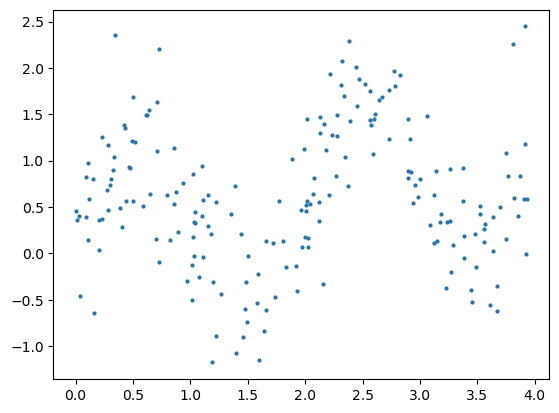

In [5]:
plt.scatter(x,y,s=4)
plt.show()

The `train_test_split` function returns the data split into two. I tend to prefer to define a list of indices for the arrays and then split these because that gives me more flexibility afterwards. To do that I do:

In [6]:
indices = np.arange(len(x), dtype=int)
i_train, i_test = train_test_split(indices, test_size=0.7)
print("The training set has {0} elements".format(len(i_train)))
print("The test set has {0} elements".format(len(i_train)))

The training set has 60 elements
The test set has 60 elements


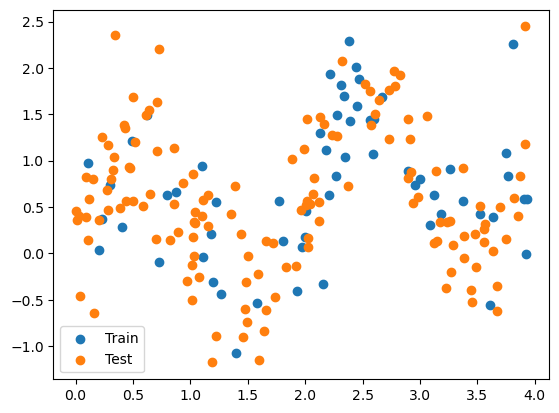

In [7]:
plt.scatter(x[i_train], y[i_train], label='Train')
plt.scatter(x[i_test], y[i_test], label='Test')
plt.legend()

We are now in a position where we can carry out fits on the training sample and evaluate the MSE on the test sample. I will also calculate two other quantities, the BIC and AIC which I'll mention below.



In [8]:
n_orders = 23 
orders = np.arange(n_orders)

MSE_train = np.zeros(n_orders)
MSE_test = np.zeros(n_orders)
BIC = np.zeros(n_orders)
AIC = np.zeros(n_orders)

best_fit = []
N = len(i_train)

for i, order in enumerate(orders):
    # Fit the training sample using polyfit
    p = np.polyfit(x[i_train], y[i_train], order)
    best_fit.append(p)
    
    # Evaluate the best fit on the training sample
    mu_fit_train = np.polyval(p, x[i_train])
    MSE_train[i] = loss_MSE(y[i_train], mu_fit_train)
    
    # Calculate the best fit on the test sample
    mu_fit_test = np.polyval(p, x[i_test])
    MSE_test[i] = loss_MSE(y[i_test], mu_fit_test)

    # And finally calculate the best information criterion
    BIC[i] = 2*N*MSE_train[i] + order*np.log10(N)
    AIC[i] = 2*order + 2*N*MSE_train[i]
    

## Looking at the result

We can now try to see what this tells us. We do this by plotting the MSE for the training and test samples.

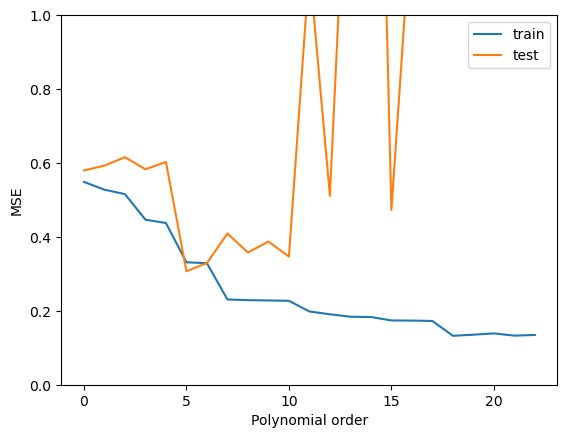

In [9]:
plt.plot(orders, MSE_train, label='train')
plt.plot(orders, MSE_test, label='test')
plt.ylim(0, 1.0)
plt.xlabel('Polynomial order')
plt.ylabel('MSE')
plt.legend()

This shows us that indeed, the training MSE drops steadily, leading us to conclude the best model according to the training sample is the one with the highest polynomial order. In contrast, the test sample shows a clear increase in the MSE at some point - it will depend on the random seed in your run what you conclude! 

### Try
Increase the number of points in the sample  and do the same run. What do you get? Is that as expected?

### Try
Run this a few times with 50 samples, what do you conclude?

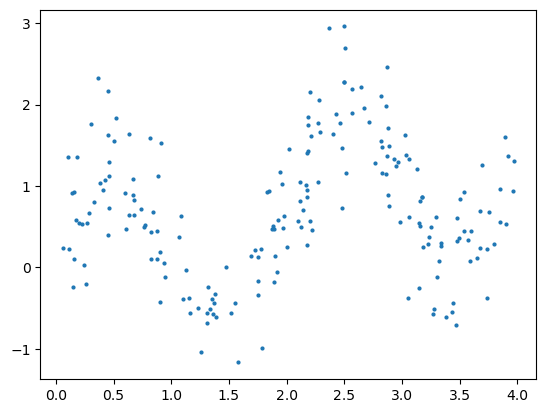

The training set has 100 elements
The test set has 100 elements


In [14]:
x, y = make_fake_data(200, true_func)
plt.scatter(x,y,s=4)
plt.show()

indices = np.arange(len(x), dtype=int)
i_train, i_test = train_test_split(indices, test_size=0.5)
print("The training set has {0} elements".format(len(i_train)))
print("The test set has {0} elements".format(len(i_train)))




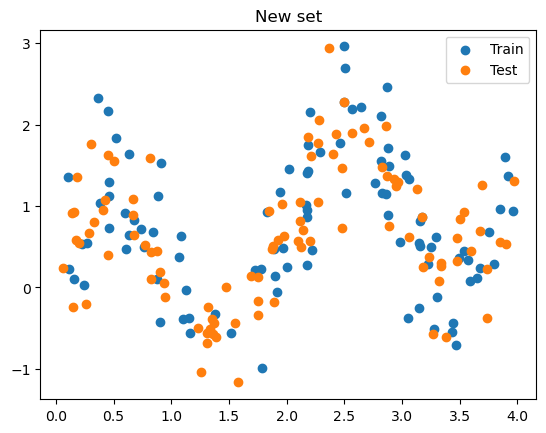

In [15]:
plt.title("New set")
plt.scatter(x[i_train], y[i_train], label='Train')
plt.scatter(x[i_test], y[i_test], label='Test')
plt.legend()

In [16]:
n_orders = 23 
orders = np.arange(n_orders)

MSE_train = np.zeros(n_orders)
MSE_test = np.zeros(n_orders)
BIC = np.zeros(n_orders)
AIC = np.zeros(n_orders)

best_fit = []
N = len(i_train)

for i, order in enumerate(orders):
    # Fit the training sample using polyfit
    p = np.polyfit(x[i_train], y[i_train], order)
    best_fit.append(p)
    
    # Evaluate the best fit on the training sample
    mu_fit_train = np.polyval(p, x[i_train])
    MSE_train[i] = loss_MSE(y[i_train], mu_fit_train)
    
    # Calculate the best fit on the test sample
    mu_fit_test = np.polyval(p, x[i_test])
    MSE_test[i] = loss_MSE(y[i_test], mu_fit_test)

    # And finally calculate the best information criterion
    BIC[i] = 2*N*MSE_train[i] + order*np.log10(N)
    AIC[i] = 2*order + 2*N*MSE_train[i]

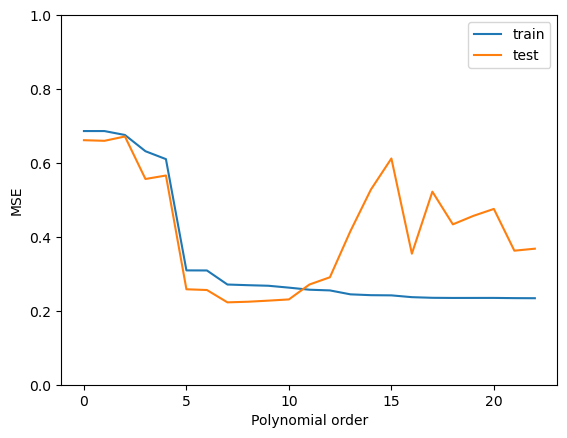

In [17]:
plt.plot(orders, MSE_train, label='train')
plt.plot(orders, MSE_test, label='test')
plt.ylim(0, 1.0)
plt.xlabel('Polynomial order')
plt.ylabel('MSE')
plt.legend()

Run with 50 samples

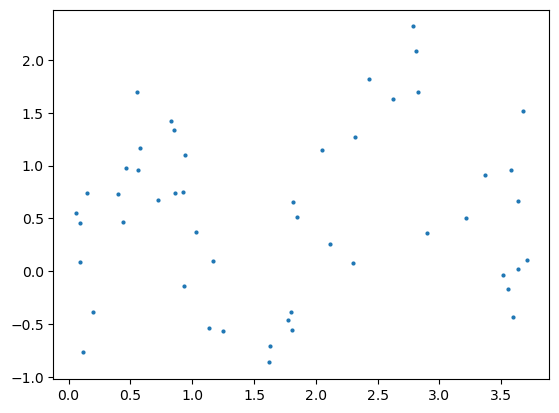

The training set has 25 elements
The test set has 25 elements


In [18]:
x, y = make_fake_data(50, true_func)
plt.scatter(x,y,s=4)
plt.show()

indices = np.arange(len(x), dtype=int)
i_train, i_test = train_test_split(indices, test_size=0.5)
print("The training set has {0} elements".format(len(i_train)))
print("The test set has {0} elements".format(len(i_test)))

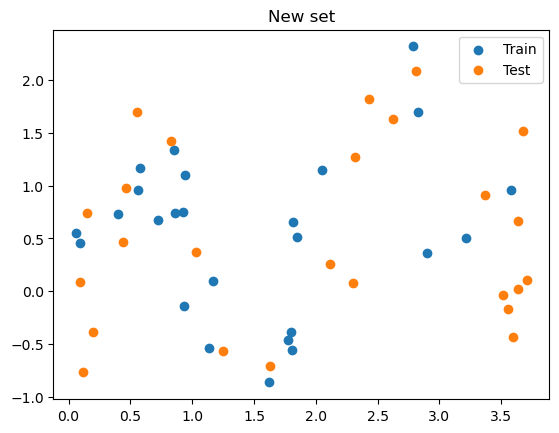

In [19]:
plt.title("New set")
plt.scatter(x[i_train], y[i_train], label='Train')
plt.scatter(x[i_test], y[i_test], label='Test')
plt.legend()

In [20]:
n_orders = 23 
orders = np.arange(n_orders)

MSE_train = np.zeros(n_orders)
MSE_test = np.zeros(n_orders)
BIC = np.zeros(n_orders)
AIC = np.zeros(n_orders)

best_fit = []
N = len(i_train)

for i, order in enumerate(orders):
    # Fit the training sample using polyfit
    p = np.polyfit(x[i_train], y[i_train], order)
    best_fit.append(p)
    
    # Evaluate the best fit on the training sample
    mu_fit_train = np.polyval(p, x[i_train])
    MSE_train[i] = loss_MSE(y[i_train], mu_fit_train)
    
    # Calculate the best fit on the test sample
    mu_fit_test = np.polyval(p, x[i_test])
    MSE_test[i] = loss_MSE(y[i_test], mu_fit_test)

    # And finally calculate the best information criterion
    BIC[i] = 2*N*MSE_train[i] + order*np.log10(N)
    AIC[i] = 2*order + 2*N*MSE_train[i]

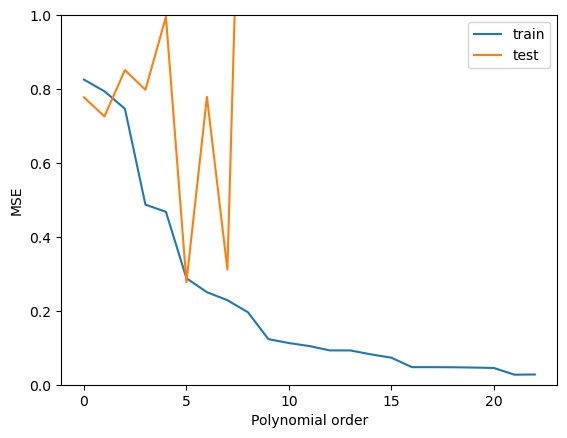

In [17]:
plt.plot(orders, MSE_train, label='train')
plt.plot(orders, MSE_test, label='test')
plt.ylim(0, 1.0)
plt.xlabel('Polynomial order')
plt.ylabel('MSE')
plt.legend()

## BIC and AIC

If we have few datapoints, the train-test split is not always feasible. In these cases (and many others as well!) you might prefer to use a simpler method to assess models. 

This is offered by _information criteria_. The two most popular are the [Bayesian Information Criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion) (BIC) and the [Akaike Information Criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion) (AIC), which are defined as 

$$
\mathrm{BIC} = M \log_{10} N - 2\ln L_{\mathrm{max}},
$$
where $L_{\mathrm{max}}$ is the maximum likelihood of the model (the best fit). If we assume that the likelihood is Gaussian (not a bad first assumption), the likelihood would have form 
$$
L = \prod_{i} \frac{1}{\sqrt{2\pi}\sigma_i} e^{-(y_i-y_{\mathrm{pred},i})^2/2\sigma},
$$
where the product is over the data in the sample. If we assume that the uncertainties are the same on all data points, then the log of the likelihood takes the form
$$\ln L = \mathrm{const} - \sum_i \left( y_i - -y_{\mathrm{pred},i}\right)^2 = \mathrm{const} - N \mathrm{MSE}.$$

Thus using this we can write the BIC as 

$$
\mathrm{BIC} = 2 N \mathrm{MSE} + M \log_{10} N,
$$
where $M$ is the number of parameters and $N$ the number of datapoints.  

The AIC is formally defined as 
$$
\mathrm{AIC} = 2 M - 2 \ln L_{\mathrm{max}}
$$
which similarly is transformed into
$$
\mathrm{AIC} = 2 M + 2 N \mathrm{MSE}
$$.

We then look for the minimum BIC and AIC. I calculated these above so let us try:

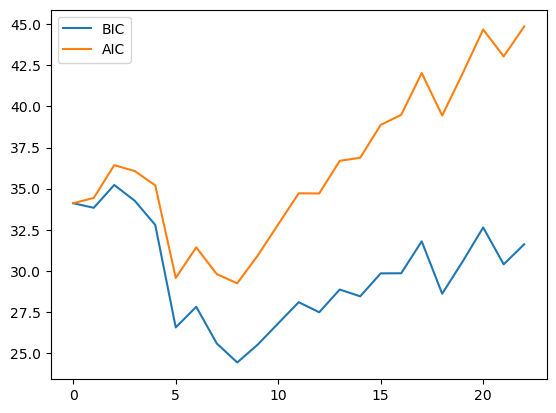

In [11]:
plt.plot(orders, BIC, label='BIC')
plt.plot(orders, AIC, label='AIC')
plt.legend()

Depending on your run you likely will find a minimum for the AIC and BIC - this then represents the best fit model. And conveniently, it only needed the test data for this. This is a reason why frequently people choose to use AIC or BIC as a quick way to choose the best model and they can definitely be useful for that. In general, however, evaluation on a test set is considered a more rigorous way to assess quality of fit.

The way to interpret the AIC and BIC scores is as relative log likelihoods so that if you have a set of models with minimum AIC of $a_m$ and another model with AIC $a_x$, then the likelihood of the second model relative to the minimum AIC model is $\propto e^{a_m-a_x}$. Thus if you have two models that differ very little in AIC you may not have good evidence that it is significantly better than the other one. 

One note of caution in both cases: finding the best fitting model does not mean that it fits well! In this particular case, we know that the true function is a sinusoidal and we are therefore fitting with the wrong family of functions.

## How should I split my data? 

There is no rigorous analysis available for the optimal way to split a dataset into test and training sample, but we can make some general considerations:

1. In general increasing the training sample reduces the random uncertainties on the parameter estimates. This is in general desirable (at least if the model is a decent fit to the data!)
2. The size of the test sample is less important as long as it is reasonably large.

These considerations have typically led to the recommendation that we split the sample into 80% training data and 20% test data. This is reasonable for moderately large samples, but if the number of data points in your samples reaches $10^6$ and above, a 80-20 split would lead to unnecessarily large test samples, and for that reason the recommendation for very large samples is to go down to splits like 99%/1%. The details are unlikely to be important as long has you have a few thousand samples in the test set.

## Training, test and validation

The idea of having a test set is to test the quality of the fitted model, removing the dependence on the training data. However, since the test set is used in the choice of the model, it is not really independent of the model fitting. For the example seen here this is not terribly problematic, but in large models this can be an important issue.

For that reason, if you have enough data you should really split your data in three: 

- Training data. This is typically the largest chunk of the data and is used to fit the parameters of the model considered at each step. 
- Validation data. This is the data that are used to check the performance of the fitted model at each step (what we called test data above).
- Test data. These are data that are not involved at all in the model fitting - they are kept outside. They are sometimes called the holdout data. We use these data at the end of the whole training process to give a final quantification of the quality of the fitted model.

Unfortunately the literature, and the information you come across on the web, is not uniform in the choice of names for the last two sets and indeed you will sometimes see test and validation swapped. 


The `train_test_split` function does not have a function to split the data in three, but it is easy to do it in a two step process: first split into training and test+validation data and then split the test+validation data into test and validation data:



In [12]:
xbig, ybig = make_fake_data(500, true_func)
indices = np.arange(len(xbig), dtype=int)
i_train, i_test_validation = train_test_split(indices, train_size=0.8)
i_test, i_validation = train_test_split(indices[i_test_validation], test_size=0.5)

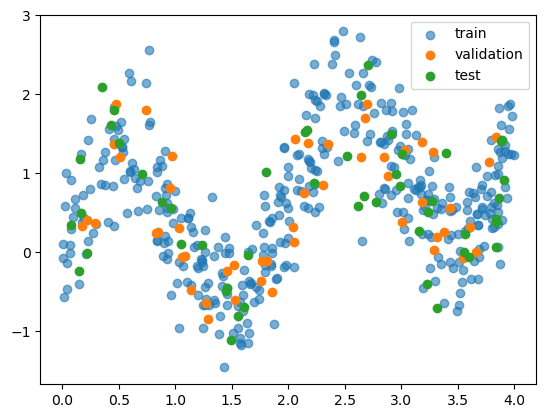

In [13]:
plt.scatter(xbig[i_train], ybig[i_train], label='train', alpha=0.6)
plt.scatter(xbig[i_validation], ybig[i_validation], label='validation')
plt.scatter(xbig[i_test], ybig[i_test], label='test')
plt.legend()

# Cross-validation

The test-training split is a bit ad hoc and while it often works quite well, it is not ideal for small and moderately sized data because you do not make use of all your data and you depend on the selection that is done, that it has not created some subtle systematic differences between your test and training data.

For that reason it is often better to opt for cross-validation. Cross validation is like training-test splits but iterated over the whole data. The two figures below shows how this works for when you divide the sample into five groups (folds), what we call 5-fold cross-validation. 

![](https://upload.wikimedia.org/wikipedia/commons/1/1c/K-fold_cross_validation_EN.jpg)

<div>
<img src="https://miro.medium.com/max/2736/1*rgba1BIOUys7wQcXcL4U5A.png" width="480"/>
</div>

`sklearn` has routines to do cross validation, so let us see how to do this

In [14]:
from sklearn.model_selection import KFold, cross_validate

`KFold` creates a set of train/test samples that we can loop over and do our inference on. `cross_validate` can be used to simplify the whole process. So to replicate the procedure above for the polynomial fitting we might do something like

```
kf = KFold(5)
<.. Setup variables ..>

for order in orders:
    for train_index, test_index in kf.split(X):
        <... Setup the model - it should be cleared for each CV run ...>

        model.fit(X_train, y_train)

        <... Calculate MSE and CV score on test sample...>
```

Clearly the inner loop should then go in a function. And for reasons that will be clear soon, it is convenient to have this in a class that is `sklearn` compatible. So this can take the form like this:


In [15]:
# Significantly extended from https://stackoverflow.com/questions/32660231/how-to-fit-a-polynomial-curve-to-data-using-scikit-learn
from sklearn.base import BaseEstimator, RegressorMixin

class PolyEstimator(BaseEstimator, RegressorMixin):
    def __init__(self, degree=2):
        self.degree = degree
        self.z = None
        self.coefficients = None
        
    def fit(self, x, y):
        params, resid, rank, singular_values, rcond = np.polyfit(x.flatten().tolist(), y, self.degree, full=True)
        self.z = np.poly1d(params)
        self.coefficients = self.z.c


    def score(self, X, y):
        y_pred = self.predict(X)
        return loss_MSE(y, y_pred)

    def predict(self, x):
        return self.z(x.flatten().tolist())

    def __str__(self):
        print(self.z)
        return ''

In [16]:
# Which can be used as follows:
poly = PolyEstimator(degree=5)
X = x[:, None]
poly.fit(X, y)
print(poly)

        5         4         3         2
0.3503 x - 3.515 x + 12.36 x - 17.73 x + 8.924 x - 0.1681



In [17]:
X

array([[1.33547308],
       [2.09619901],
       [1.36897428],
       [1.06875645],
       [1.26225698],
       [1.51613743],
       [2.26185775],
       [1.07500669],
       [1.14493467],
       [0.68913123],
       [2.14908742],
       [0.06444406],
       [1.29658024],
       [0.90279102],
       [0.86873626],
       [3.02883782],
       [0.45361042],
       [1.74224379],
       [2.5649078 ],
       [3.16200391],
       [1.31017606],
       [2.41000468],
       [1.12602892],
       [1.93546929],
       [1.02107222],
       [3.30795289],
       [3.84528003],
       [3.04750603],
       [2.72920616],
       [2.97840759],
       [1.12496834],
       [2.09354227],
       [3.15562119],
       [3.636179  ],
       [2.64559624],
       [3.7938452 ],
       [2.08238672],
       [0.85093823],
       [3.91159773],
       [0.16827376],
       [0.53852753],
       [0.31411165],
       [3.40381915],
       [1.09279741],
       [1.74054522],
       [1.61357274],
       [0.65778649],
       [2.741

In [18]:
x

array([1.33547308, 2.09619901, 1.36897428, 1.06875645, 1.26225698,
       1.51613743, 2.26185775, 1.07500669, 1.14493467, 0.68913123,
       2.14908742, 0.06444406, 1.29658024, 0.90279102, 0.86873626,
       3.02883782, 0.45361042, 1.74224379, 2.5649078 , 3.16200391,
       1.31017606, 2.41000468, 1.12602892, 1.93546929, 1.02107222,
       3.30795289, 3.84528003, 3.04750603, 2.72920616, 2.97840759,
       1.12496834, 2.09354227, 3.15562119, 3.636179  , 2.64559624,
       3.7938452 , 2.08238672, 0.85093823, 3.91159773, 0.16827376,
       0.53852753, 0.31411165, 3.40381915, 1.09279741, 1.74054522,
       1.61357274, 0.65778649, 2.74113637, 3.17553276, 3.90504029])

We can now use a CV method to assess this kind of model.

In [19]:
def cv_fit_model(X, y, degree, n_folds=5):
    kf = KFold(n_folds)

    # CV scores in our model is the mean square error
    cv_scores = []

    N = len(y)
    for train_index, test_index in kf.split(X):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]

        model = PolyEstimator(degree=degree)
        model.fit(X_train, y_train)
        cv_scores.append(model.score(X_test, y_test))

    mean_cv_score = np.mean(cv_scores)
    std_cv_score = np.std(cv_scores)

    return mean_cv_score, std_cv_score

# Checking that it works:
# mean_cv, std_cv = cv_fit_model(X, y, 5, n_folds=5)
# print("CV score = {0:.3f} +/- {1:.3f}".format(mean_cv, std_cv))

In [20]:
N_folds = 10
mean_cv_scores = np.zeros(len(orders))
std_cv_scores = np.zeros(len(orders))
for i, order in enumerate(orders):
    mean_cv, std_cv = cv_fit_model(X, y, order, n_folds=N_folds)

    mean_cv_scores[i] = mean_cv
    std_cv_scores[i] = std_cv


Text(0, 0.5, 'mean CV score [MSE]')

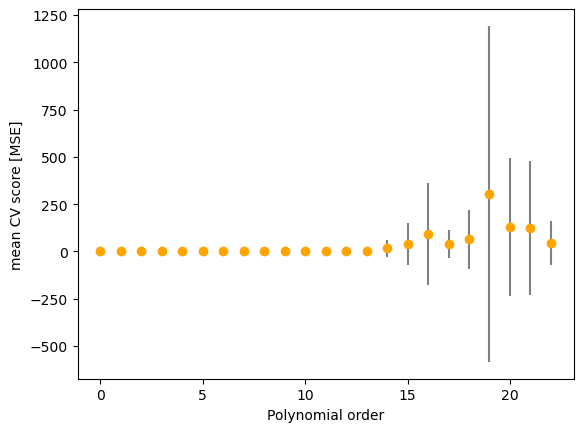

In [21]:
plt.errorbar(orders, mean_cv_scores, std_cv_scores, marker='o', fmt='none', color='gray')
plt.scatter(orders, mean_cv_scores, marker='o', color='orange', zorder=10)
plt.xlabel('Polynomial order')
plt.ylabel('mean CV score [MSE]')
#plt.yscale("log")

One issue that you immediately can notice is that calculating standard deviation makes little sense when the scatter is large! Reduce the number of K-folds to see less scatter, or modify the code to use the 16th and 84th percentile instead to get appropriate asymmetric error bars.

We can also simplify the process above because that particular way to run things is standard. This is what the `cross_validate` convenience function does for us

In [22]:
mean_cvs = np.zeros(len(orders))
std_cvs = np.zeros(len(orders))
for i, order in enumerate(orders):
    cv = cross_validate(estimator=PolyEstimator(degree=order), 
        X=X, y=y, cv=5)
    mean_cvs[i] = np.mean(cv['test_score'])
    std_cvs[i] = np.std(cv['test_score'])

Since we had already written a function to do the Cross-validation calculation, there was nothing really to be gained here but in general this saves us from writing that function and also it has a lot of other powerful aspects to it. 

Finally, we can also avoid writing the loop above by using `GridSearchCV`. This requires an estimator, a grid of parameters to explore and a cross-validation object. The grid of parameters is created using a dictionary with the keys equal to the keyword used to specify the parameters in the estimator ('degree' in our case here). So all the code above can be simplified into: 

In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {'degree': np.arange(1, 25)}
cv = KFold(5)
search = GridSearchCV(estimator=PolyEstimator(),         # Estimator to use
                      param_grid=param_grid,             # The grid of parameters to explore
                      scoring="neg_mean_squared_error",  # The scoring function (many possibilities here)
                      cv=cv)                             # The cross-validation object to use for the search
search.fit(X, y)
print("The best order = {0}".format(search.best_params_))

The best order = {'degree': 7}


You hopefully see that this is much more compact and _if_ you understand what you are doing, it is also much more readable. However, there is a risk that you get overly confident in the result - because if you look at how the MSE varies with order you are probably less confident that a degree of 5 is the best fit without doubt than if you used the `GridSearchCV` approach above.

All that said, the `GridSearchCV` function is very useful and in complex situations can help streamline complex optimization problems. 

# Task: A polynomial fit to cosmological data

The next three boxes creates a sample dataset of supernova Ia distances that you should fit with a polynomial. Find the best-fitting polynomial degree.

In [103]:
from astropy.cosmology import WMAP9 as cosmo

In [104]:

#------------------------------------------------------------
# Generate data - see http://www.astroml.org/book_figures/chapter8/fig_gp_mu_z.html
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=0, cosmo=cosmo)
z = np.linspace(0.01, 2, 1000)
mu_true = np.asarray(cosmo.distmod(z))


array([0.9531149 , 0.96655138, 0.95737219, 0.95280487, 0.94302204,
       0.96081495, 0.94418263, 0.98489454, 0.99872878, 0.93958455,
       0.97349213, 0.9515419 , 0.95463081, 0.99019306, 0.89679761,
       0.90112516, 0.87260665, 0.97768215, 0.97219178, 0.98202338,
       1.00407211, 0.97422126, 0.946144  , 0.97241648, 0.9078953 ,
       0.9603342 , 0.91237085, 0.99393869, 0.95098399, 0.94226534,
       0.92819244, 0.97182256, 0.94570937, 0.9546615 , 0.87129655,
       0.95855271, 0.95811233, 0.9584969 , 0.99373876, 0.96374616,
       0.93746239, 0.94413663, 0.96506343, 0.89339716, 0.96250869,
       0.96282551, 0.92194128, 0.90987941, 0.93335774, 0.93783984,
       0.95480045, 0.9442666 , 1.00946842, 0.90457778, 0.92175266,
       0.91521501, 0.96139779, 0.92696761, 0.94653677, 0.92597858,
       0.91485846, 0.9063298 , 0.96165888, 0.9115014 , 0.92017564,
       0.9382874 , 0.97644274, 0.90348228, 0.97826499, 0.9032545 ,
       1.00315253, 0.94672662, 1.003277  , 0.95753715, 0.96864

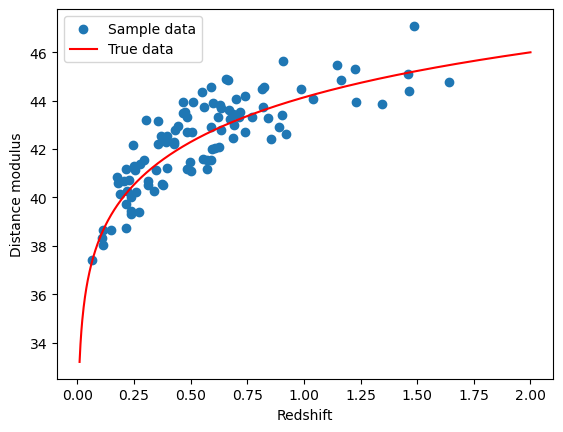

In [108]:
plt.scatter(z_sample, mu_sample,label="Sample data")
plt.plot(z,mu_true,label="True data",color="red")
plt.xlabel('Redshift')
plt.ylabel('Distance modulus')
plt.legend()
plt.show()

#### Primeiro vou usar o último código que ele utiliza

In [116]:
### Aqui para determinar qual o grau do polinómio que devo utilizar

X=z_sample[:,None]

param_grid = {'degree': np.arange(1, 30)}
cv = KFold(5)
search = GridSearchCV(estimator=PolyEstimator(),         # Estimator to use
                      param_grid=param_grid,             # The grid of parameters to explore
                      scoring="neg_mean_squared_error",  # The scoring function (many possibilities here)
                      cv=cv)                             # The cross-validation object to use for the search
search.fit(X,mu_sample)
print("The best order = {0}".format(search.best_params_))

The best order = {'degree': 4}


array([ 9.21260911e-01,  4.30802480e+01,  3.32426390e-01, -1.80149738e-01,
       -1.97502807e-02, -4.32833030e+00,  8.55111208e+01,  1.08113240e+00,
       -1.58027385e-01,  6.15872546e+00,  1.33800107e+00,  2.40848394e-01,
        1.43750754e+00,  3.38903474e+00,  3.40861678e+00, -3.95052598e+03,
       -9.08417216e-01,  1.81771212e+01,  5.42226646e+00,  2.59870976e+00,
        2.72453992e+00,  3.38485054e+00,  8.99493834e-01,  1.05826866e+00,
        4.20018601e+00])